
Processing Run 1...
  Run 1 t0 (first container start): 2025-05-07 15:14:01 UTC (1746630841.000s epoch)


/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7808/4174414858.py:173: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mcperf_df = pd.read_csv(mcperf_file, delim_whitespace=True, names=col_names, skiprows=header_line_num, comment='#')


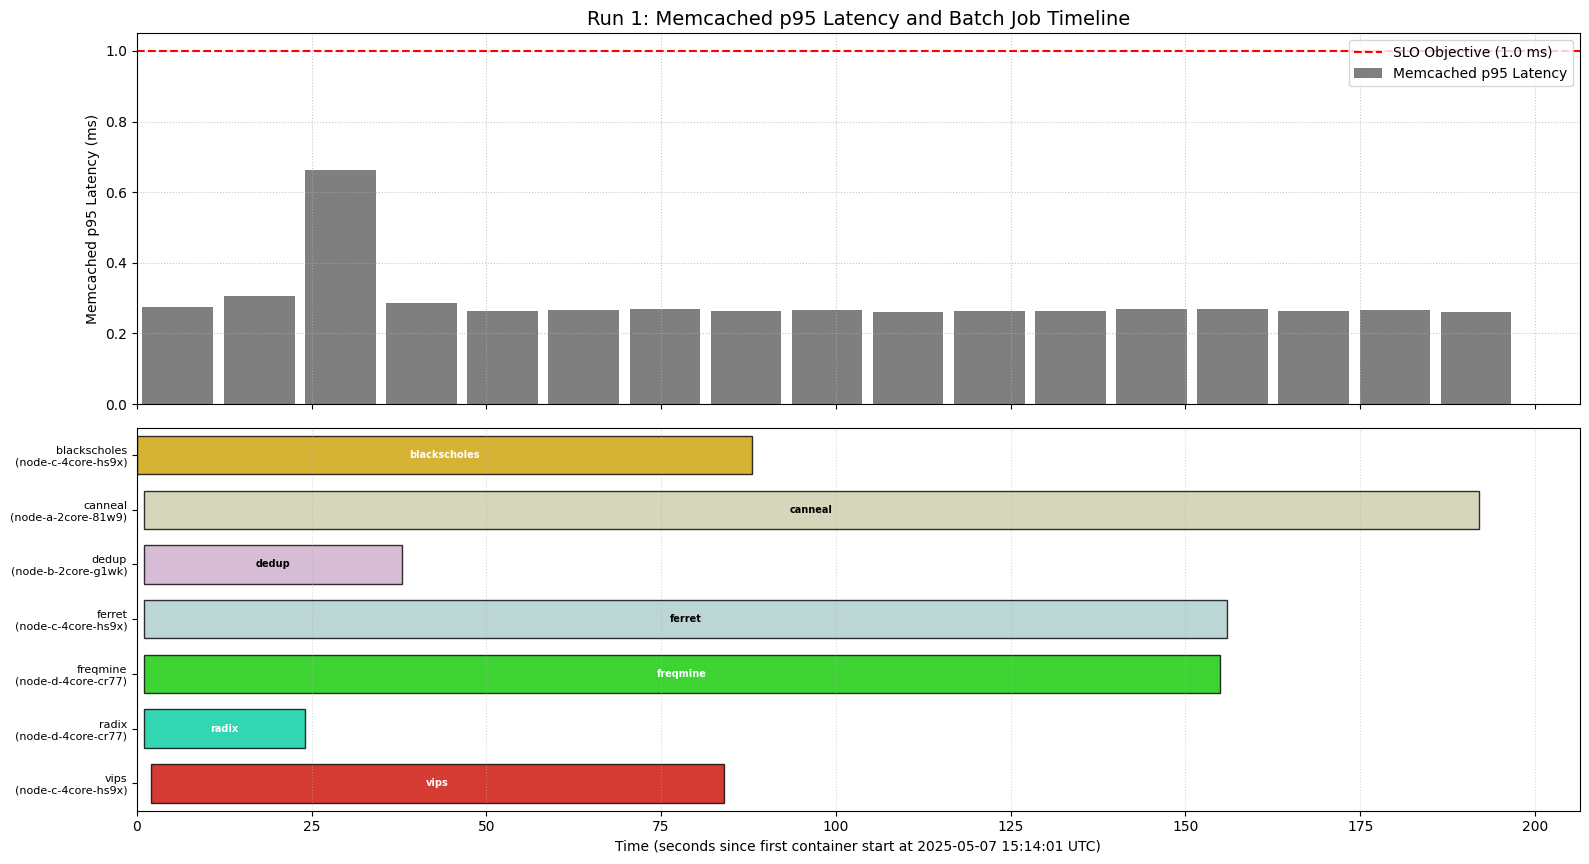


Processing Run 2...
  Run 2 t0 (first container start): 2025-05-07 15:23:22 UTC (1746631402.000s epoch)


/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7808/4174414858.py:173: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mcperf_df = pd.read_csv(mcperf_file, delim_whitespace=True, names=col_names, skiprows=header_line_num, comment='#')


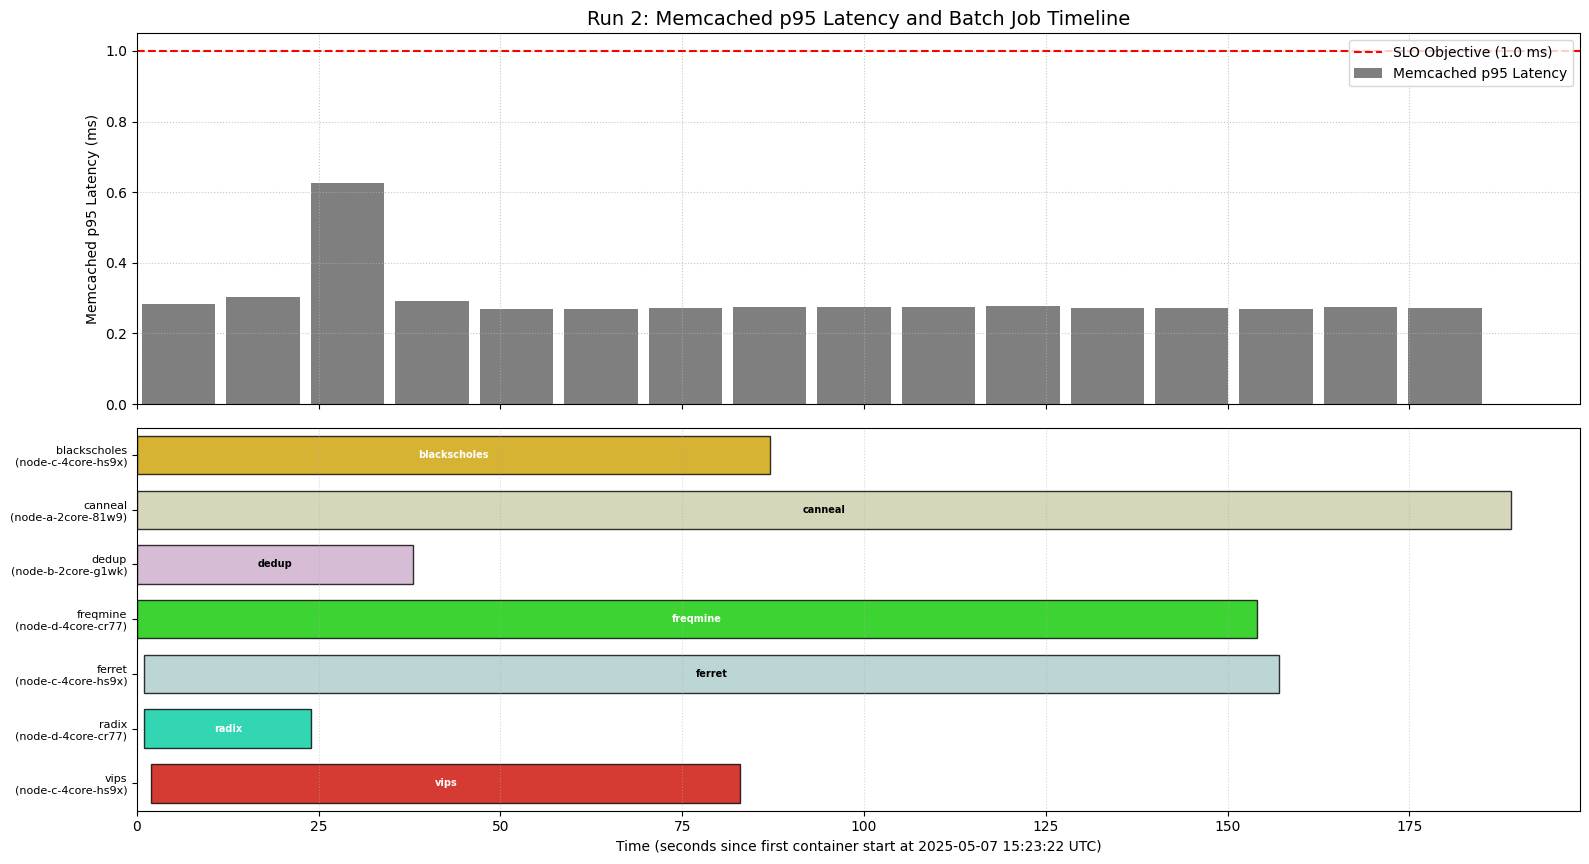


Processing Run 3...
  Run 3 t0 (first container start): 2025-05-07 15:29:52 UTC (1746631792.000s epoch)


/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7808/4174414858.py:173: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mcperf_df = pd.read_csv(mcperf_file, delim_whitespace=True, names=col_names, skiprows=header_line_num, comment='#')


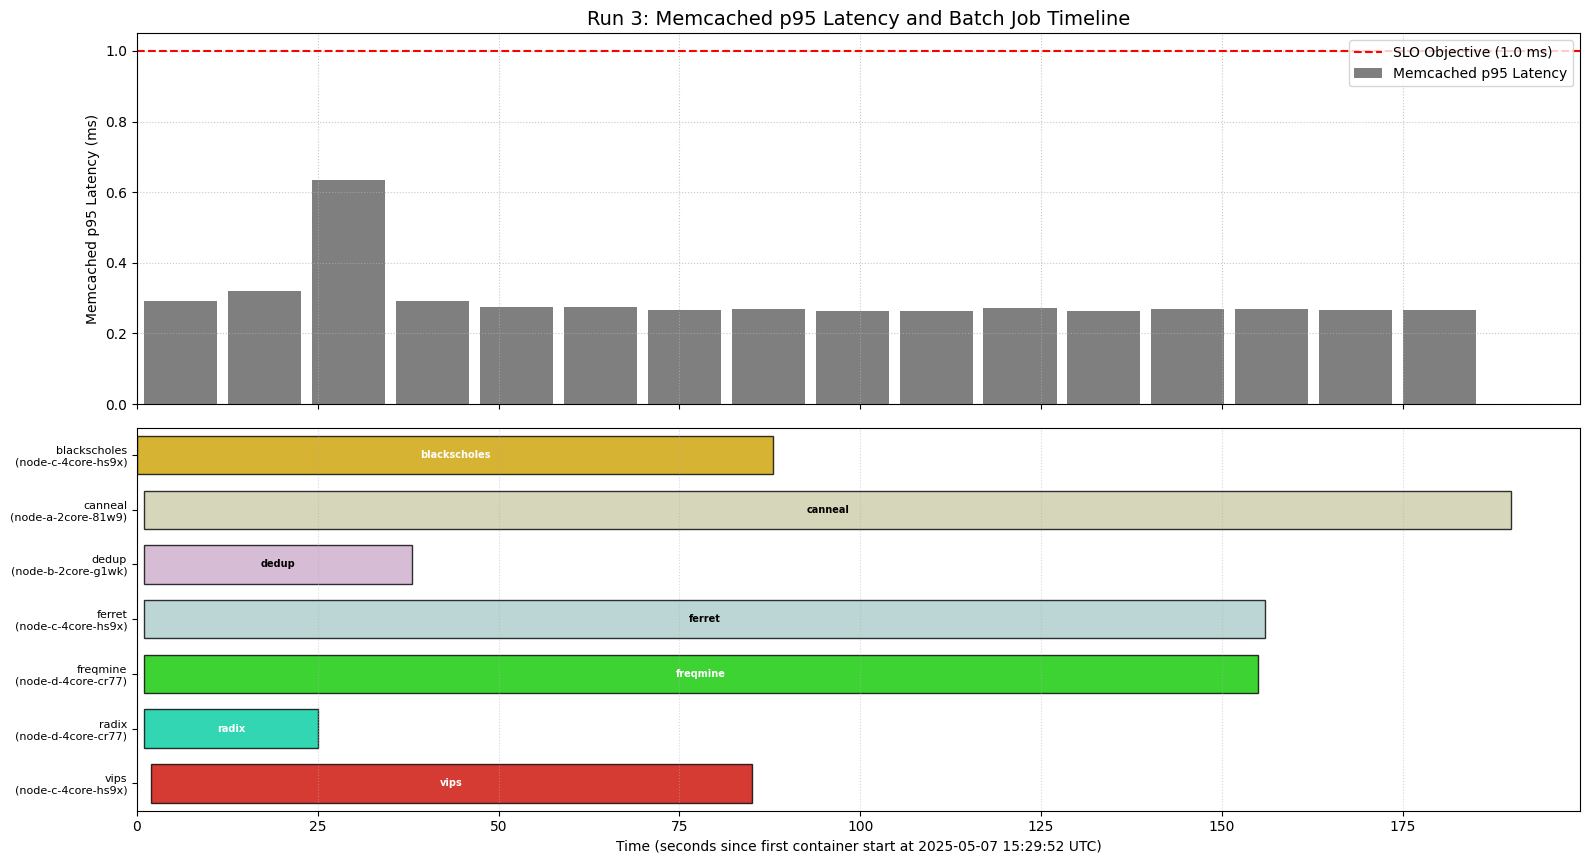


Finished processing all available runs.


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timezone
import os
import re

# %matplotlib inline # Or %matplotlib widget for interactive plots in JupyterLab/VSCode

# --- Configuration ---
# !!! IMPORTANT: UPDATE THESE COLORS FROM YOUR main.tex !!!
# Keys should match the 'job-name' label from pods_*.json (e.g., "parsec-canneal")
# or the specific name for memcached if you want to color its latency bars differently.
JOB_COLORS = {
    'parsec-blackscholes': '#CCA000',  # From \definecolor{blackscholes}{HTML}{CCA000}
    'parsec-canneal':    '#CCCCAA',  # From \definecolor{canneal}{HTML}{CCCCAA}
    'parsec-dedup':      '#CCACCA',  # From \definecolor{dedup}{HTML}{CCACCA}
    'parsec-ferret':     '#AACCCA',  # From \definecolor{ferret}{HTML}{AACCCA}
    'parsec-freqmine':   '#0CCA00',  # From \definecolor{freqmine}{HTML}{0CCA00}
    'parsec-radix':      '#00CCA0',  # From \definecolor{radix}{HTML}{00CCA0}
    'parsec-vips':       '#CC0A00',  # From \definecolor{vips}{HTML}{CC0A00}
    
    # --- Keep these or adjust as needed ---
    'memcached':         '#7f7f7f',  # Example: Grey (for the memcached p95 latency bars)
                                     # You might want to define a specific color for memcached too
    'other':             '#bcbd22'   # Example: Olive (for any unmapped jobs)
}
SLO_OBJECTIVE = 1.0  # ms (Service Level Objective for p95 latency)


# --- Helper Functions ---

def parse_iso_to_epoch_seconds(iso_timestamp_str):
    """Converts an ISO 8601 timestamp string to epoch seconds (UTC)."""
    if not iso_timestamp_str:
        return None
    try:
        # Handle timestamps with or without fractional seconds and Zulu timezone
        if '.' in iso_timestamp_str and iso_timestamp_str.endswith('Z'):
            dt_obj = datetime.strptime(iso_timestamp_str, "%Y-%m-%dT%H:%M:%S.%fZ")
        elif iso_timestamp_str.endswith('Z'):
            dt_obj = datetime.strptime(iso_timestamp_str, "%Y-%m-%dT%H:%M:%SZ")
        else: # Attempt to parse with timezone offset if Z is not present
            dt_obj = datetime.strptime(iso_timestamp_str, "%Y-%m-%dT%H:%M:%S%z")
        return dt_obj.replace(tzinfo=timezone.utc).timestamp() # Standardize to UTC epoch
    except ValueError as e:
        print(f"Warning: Could not parse timestamp '{iso_timestamp_str}': {e}. Trying without fractional seconds.")
        try: # Fallback for missing fractional seconds
            if iso_timestamp_str.endswith('Z'):
                 dt_obj = datetime.strptime(iso_timestamp_str, "%Y-%m-%dT%H:%M:%SZ")
            else:
                 dt_obj = datetime.strptime(iso_timestamp_str, "%Y-%m-%dT%H:%M:%S%z")
            return dt_obj.replace(tzinfo=timezone.utc).timestamp()
        except ValueError as e2:
            print(f"Error: Still could not parse timestamp '{iso_timestamp_str}': {e2}")
            return None


def get_container_start_time_epoch(pod_status):
    """Extracts the earliest start time from container statuses in a pod."""
    start_times_epoch = []
    if 'containerStatuses' in pod_status and pod_status['containerStatuses']:
        for cs in pod_status['containerStatuses']:
            if 'state' in cs:
                if 'running' in cs['state'] and cs['state']['running'] and 'startedAt' in cs['state']['running']:
                    epoch_time = parse_iso_to_epoch_seconds(cs['state']['running']['startedAt'])
                    if epoch_time:
                        start_times_epoch.append(epoch_time)
                elif 'terminated' in cs['state'] and cs['state']['terminated'] and 'startedAt' in cs['state']['terminated']:
                    epoch_time = parse_iso_to_epoch_seconds(cs['state']['terminated']['startedAt'])
                    if epoch_time:
                        start_times_epoch.append(epoch_time)
    return min(start_times_epoch) if start_times_epoch else None

def get_pod_job_info(pod_data, t0_run_seconds):
    """Extracts job name, node, relative start/end times for a batch job pod."""
    job_info_list = []
    for pod in pod_data['items']:
        pod_name = pod['metadata'].get('name', 'unknown_pod')
        # Use 'job-name' from labels for batch jobs
        job_name_label = pod['metadata'].get('labels', {}).get('job-name')
        
        # We are interested in batch jobs (typically parsec-*).
        # The memcached pod's start time contributes to t0_run_seconds but isn't plotted as a batch job here.
        if not job_name_label or "memcached" in pod_name.lower(): 
            continue

        node_name = pod['spec'].get('nodeName', 'unknown_node')
        
        # Assuming one primary container per batch job pod for start/finish times
        container_status = pod['status'].get('containerStatuses', [{}])[0] 
        
        start_time_iso = None
        finish_time_iso = None

        if 'state' in container_status and 'terminated' in container_status['state'] and container_status['state']['terminated']:
            start_time_iso = container_status['state']['terminated'].get('startedAt')
            finish_time_iso = container_status['state']['terminated'].get('finishedAt')
        else:
            print(f"Warning: Pod {pod_name} (job: {job_name_label}) is not in a terminated state or lacks container status. Skipping for timeline.")
            continue


        start_epoch = parse_iso_to_epoch_seconds(start_time_iso)
        finish_epoch = parse_iso_to_epoch_seconds(finish_time_iso)

        if start_epoch is not None and finish_epoch is not None and t0_run_seconds is not None:
            job_info_list.append({
                'name': job_name_label,
                'node': node_name,
                'start_relative_s': start_epoch - t0_run_seconds,
                'end_relative_s': finish_epoch - t0_run_seconds,
                'color': JOB_COLORS.get(job_name_label, JOB_COLORS['other'])
            })
        else:
            print(f"Warning: Missing time data for job {job_name_label} on {node_name}. Cannot plot.")
            
    return job_info_list

# --- Main Plotting Loop ---
for run_number in [1, 2, 3]:
    mcperf_file = f'mcperf_{run_number}.txt'
    pods_file = f'pods_{run_number}.json'

    if not os.path.exists(mcperf_file) or not os.path.exists(pods_file):
        print(f"Skipping Run {run_number}: Data files not found ({mcperf_file} or {pods_file}).")
        continue

    print(f"\nProcessing Run {run_number}...")

    # 1. Load Pods Data and Determine t0_run_seconds
    try:
        with open(pods_file, 'r') as f:
            pods_data = json.load(f)
    except Exception as e:
        print(f"Error loading pods_file {pods_file}: {e}")
        continue

    all_container_start_times_epoch = []
    for item in pods_data.get('items', []):
        labels = item.get('metadata', {}).get('labels', {})
        job_name_label = labels.get('job-name', '')
        if not job_name_label or not job_name_label.startswith("parsec-"):
            continue  # Only include batch jobs
        start_time = get_container_start_time_epoch(item.get('status', {}))
        if start_time:
            all_container_start_times_epoch.append(start_time)

    
    if not all_container_start_times_epoch:
        print(f"Error: Could not determine any container start times for Run {run_number} from {pods_file}.")
        continue
        
    t0_run_seconds = min(all_container_start_times_epoch)
    t0_datetime_str = datetime.fromtimestamp(t0_run_seconds, timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')
    print(f"  Run {run_number} t0 (first container start): {t0_datetime_str} ({t0_run_seconds:.3f}s epoch)")

    # 2. Load and Process mcperf Data
    mcperf_df = None
    try:
        # Try to read mcperf data, identify header line for column names
        col_names = None
        header_line_num = 0
        with open(mcperf_file, 'r') as f_mcperf:
            for i, line in enumerate(f_mcperf):
                if line.strip().startswith('#type'): # Look for the specific header
                    col_names = re.split(r'\s+', line.strip('#').strip())
                    header_line_num = i + 1 # Data starts on the next line
                    break
        
        if col_names:
            mcperf_df = pd.read_csv(mcperf_file, delim_whitespace=True, names=col_names, skiprows=header_line_num, comment='#')
        else: # Fallback if specific header not found, assume first non-comment is header
            mcperf_df = pd.read_csv(mcperf_file, delim_whitespace=True, comment='#')


        # Convert timestamps (ms to s) and p95 latency (µs to ms, assuming mcperf output is µs)
        mcperf_df['ts_start_s'] = mcperf_df['ts_start'].astype(float) / 1000
        mcperf_df['ts_end_s'] = mcperf_df['ts_end'].astype(float) / 1000
        mcperf_df['p95_ms'] = mcperf_df['p95'].astype(float) / 1000 

        mcperf_df['bar_start_relative_s'] = mcperf_df['ts_start_s'] - t0_run_seconds
        mcperf_df['bar_width_s'] = mcperf_df['ts_end_s'] - mcperf_df['ts_start_s']
        
        # Filter out any data points that start significantly before our t0 (allow for small float inaccuracies)
        mcperf_df = mcperf_df[mcperf_df['bar_start_relative_s'] >= -0.01].copy() # Use .copy() to avoid SettingWithCopyWarning

    except Exception as e:
        print(f"Error processing mcperf file for Run {run_number} ({mcperf_file}): {e}")
        continue
    
    if mcperf_df is None or mcperf_df.empty:
        print(f"No mcperf data loaded for Run {run_number}.")
        continue

    # 3. Get Batch Job Information
    batch_jobs = get_pod_job_info(pods_data, t0_run_seconds)

    # 4. Plotting
    # Dynamically adjust height based on number of jobs for the timeline
    num_job_lanes = len(set(f"{job['name']}@{job['node']}" for job in batch_jobs))
    job_timeline_height_ratio = 1 + num_job_lanes * 0.3 # Base ratio + per job lane
    if num_job_lanes == 0: job_timeline_height_ratio = 0.5 # Smaller if no jobs

    fig, (ax_latency, ax_jobs_timeline) = plt.subplots(2, 1, figsize=(16, 6 + num_job_lanes * 0.5), sharex=True, 
                                                       gridspec_kw={'height_ratios': [3, job_timeline_height_ratio]})

    # Plot Memcached p95 Latency
    ax_latency.bar(mcperf_df['bar_start_relative_s'], mcperf_df['p95_ms'], 
                   width=mcperf_df['bar_width_s'], align='edge', 
                   color=JOB_COLORS.get('memcached', '#7f7f7f'), label='Memcached p95 Latency')
    ax_latency.axhline(SLO_OBJECTIVE, color='red', linestyle='--', label=f'SLO Objective ({SLO_OBJECTIVE} ms)')
    ax_latency.set_ylabel('Memcached p95 Latency (ms)')
    ax_latency.set_title(f'Run {run_number}: Memcached p95 Latency and Batch Job Timeline', fontsize=14)
    ax_latency.legend(loc='upper right')
    ax_latency.grid(True, linestyle=':', alpha=0.7)

    # Plot Batch Job Timeline (Gantt-like)
    job_y_positions = {} # To map job_id to y-lane
    y_labels = {} # To store labels for y-ticks
    current_y_lane = 0
    
    # Sort jobs by start time for consistent y-lane assignment if desired, though distinct lanes are used here
    sorted_batch_jobs = sorted(batch_jobs, key=lambda x: x['start_relative_s'])

    for job in sorted_batch_jobs:
        # Create a unique ID for each job instance on a node to assign it a y-lane
        # This ensures jobs with the same name on different nodes get different lanes if they overlap
        # Or if you want all instances of "canneal" on one line regardless of node, simplify job_id
        job_id_for_lane = f"{job['name']}_{job['node']}" # Could also be just job['name'] if you want to group all instances
                                                         # Or a unique ID per pod if multiple pods for same job_name run concurrently

        if job_id_for_lane not in job_y_positions:
            job_y_positions[job_id_for_lane] = current_y_lane
            y_labels[current_y_lane] = f"{job['name'].replace('parsec-', '')}\n({job['node']})" # Store label for this lane
            current_y_lane += 1
        
        y_pos = job_y_positions[job_id_for_lane]
        duration = job['end_relative_s'] - job['start_relative_s']
        
        if duration < 0: # Should not happen with correct start/end times
            print(f"Warning: Job {job['name']} on {job['node']} has negative duration. Skipping.")
            continue

        ax_jobs_timeline.barh(y_pos, duration, left=job['start_relative_s'], height=0.7, 
                              color=job['color'], align='center', edgecolor='black', alpha=0.8)
        
        # Add text label on the bar
        text_color = 'white' if sum(int(job['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) / 3 < 128 else 'black'
        # Shorten node name for display if too long
        display_node_name = job['node']
        if len(display_node_name) > 15: # Example threshold
            parts = display_node_name.split('-')
            if len(parts) > 2:
                display_node_name = f"{parts[0]}-...-{parts[-1]}"


        ax_jobs_timeline.text(job['start_relative_s'] + duration / 2, y_pos, 
                              f"{job['name'].replace('parsec-', '')}", # Only job name on bar
                              ha='center', va='center', color=text_color, fontsize=7, fontweight='bold')

    if batch_jobs and current_y_lane > 0:
        ax_jobs_timeline.set_yticks(list(y_labels.keys())) # Use the keys from y_labels dict for positions
        ax_jobs_timeline.set_yticklabels([y_labels[k] for k in sorted(y_labels.keys())], fontsize=8) # Use sorted values for labels
        ax_jobs_timeline.set_ylim(-0.5, current_y_lane - 0.5)
    else:
        ax_jobs_timeline.set_yticks([]) # No jobs, no y-ticks

    ax_jobs_timeline.set_xlabel(f'Time (seconds since first container start at {t0_datetime_str})')
    ax_jobs_timeline.grid(True, linestyle=':', alpha=0.5, axis='x') # Only x-axis grid for timeline
    ax_jobs_timeline.invert_yaxis() # Common for Gantt charts

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust subplot parameters for better layout
    plt.show()

print("\nFinished processing all available runs.")